# Pricing equity options denominated in Euro
In this notebook I price American equity options denominated in Euro using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org), [Eurostat](https://ec.europa.eu/eurostat/data/database), and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader, eurostat, yfinance
# !pip install pandas-datareader -U
# !pip install eurostat -U
# !pip install yfinance -U

## Constructing a riskless yield curve for Euro
Since I already covered it in a separate notebook, I will simply import it. The resultant YieldCurve object is
assigned to the `curve` variable

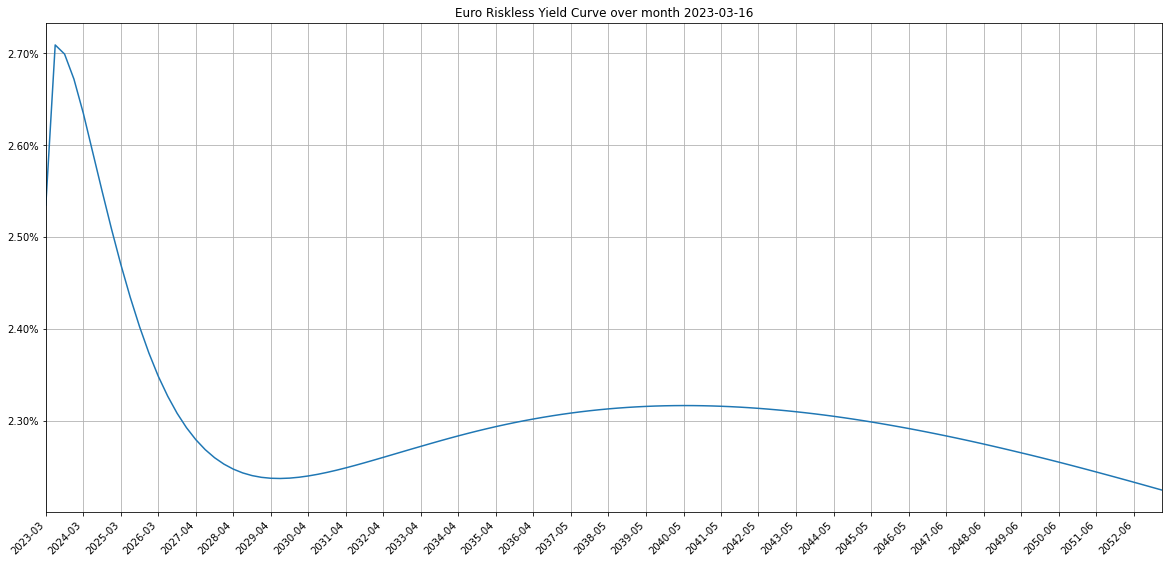

In [2]:
%run euro-riskless-yield-construction-example.ipynb

## Estimating and forecasting volatility of the stock, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the stock whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for Shell plc

In [3]:
# A kludge for pandas-datareader not being able to cope with latest Yahoo-Finance changes
import yfinance as yfin
yfin.pdr_override()

# Shell plc as traded on Euronext Amsterdam
TICKER = 'SHELL.AS'

# I'll use price changes since 1st Jan 2018 to estimate GARCH(1, 1) ω, α, and β parameters
start = date(2018, 1, 1)
data = web.get_data_yahoo(TICKER, start, today)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

[*********************100%***********************]  1 of 1 completed
Objective function: 9454.66297 after 95 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000007046213, α=0.10273, β=0.88604


##### Optional: Estimating with a faster estimator &mdash; GARCHVarianceTargetingParameterEstimator

In [4]:
var_target_vol_estimator = parameter_estimators.GARCHVarianceTargetingParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (var_target_vol_estimator.omega, var_target_vol_estimator.alpha, var_target_vol_estimator.beta))

Objective function: 9454.23535 after 30 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000007353050, α=0.09794, β=0.88647


#### Forecasting volatility for Shell plc
Now that we have obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast the volatility of Shell stock. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [6]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for September 15th options
maturity_date = date(2023, month=9, day=15)
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of SHELL.AS for term 0.4904 years: 0.42021


#### Optional: Visualizing historical and future volatility of Shell stock for 200 business days into the future

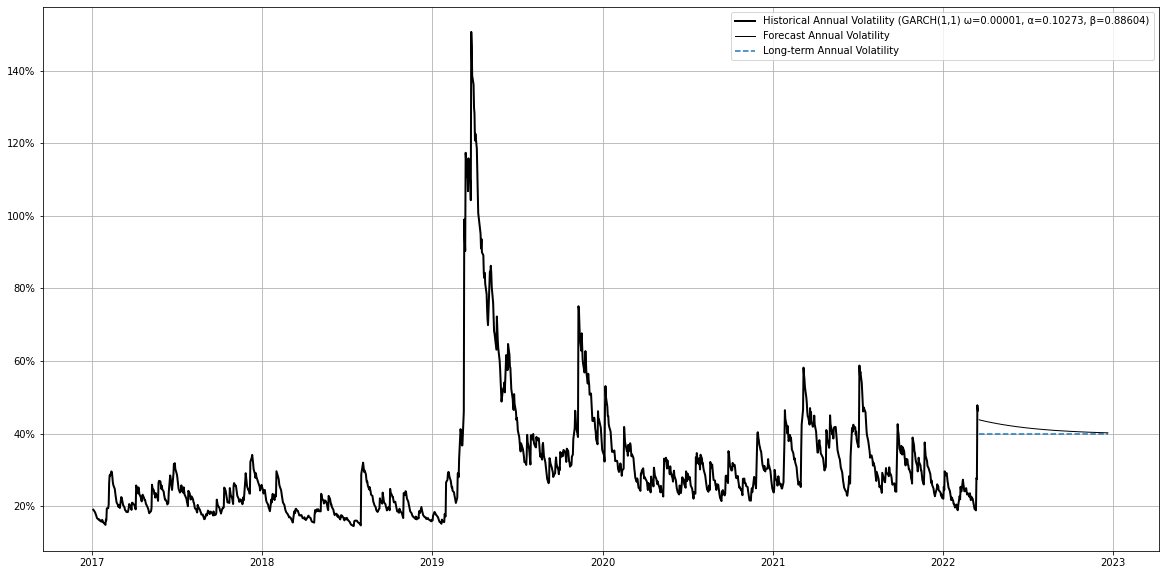

In [7]:
import matplotlib.pyplot as plt
x = vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, vol_tracker.get_annual_volatilities() * 100,
        label='Historical Annual Volatility (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)' 
            % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta),
        linewidth=2, color='k')

# Forecasting volatility of Shell stock 200 days into the future
future_volatilities = vol_tracker.get_annual_volatility_forecast_for_next_n_days(200)
ax.plot(future_volatilities.index, future_volatilities * 100, label='Forecast Annual Volatility', linewidth=1, color='k')
ax.hlines(vol_tracker.get_annual_long_term_volatility() * 100, xmin=future_volatilities.index[0], xmax=future_volatilities.index[-1],
         label="Long-term Annual Volatility", linestyle='--')
ax.legend()
ax.grid(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

#### Optional: Visualizing the volatility term structure of Shell stock for 5 years into the future
A very important notion in pricing options is the _volatility term structure_. It defines the relationship between
the maturity of options and their volatilities. In other words it defines what the average volatility for a given maturity is forecast to be. Given the mean reverting nature of volatility, volatility for the longer terms trends towards the mean volatility of a given asset.

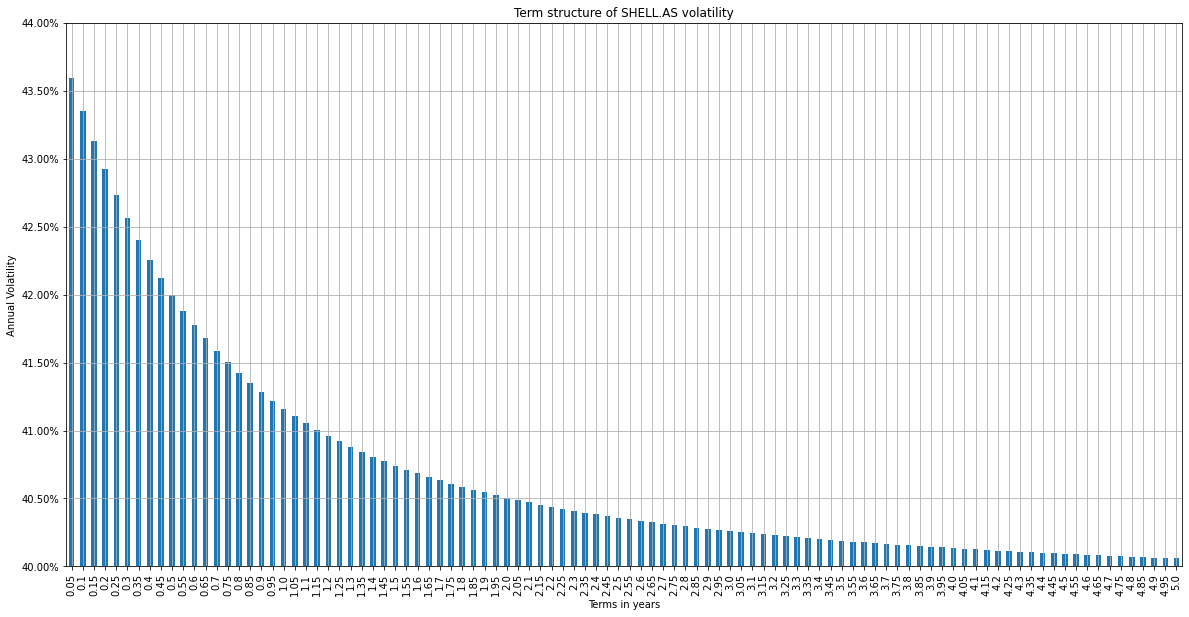

In [8]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of ' + TICKER + ' volatility')
ax.set_ylim(bottom=floor(series.min()), top=ceil(series.max()))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including on stock that pays dividends. With enough customizations it can also be used to price American call options (even those paying dividends). This is based on the fact that it is never optimal to exercise an American call option prematurely except on days immediately preceeding ex-dividend days for the stock. The `pricing.options.BlackScholesMertonPricer` class from this repository implements this customization to price American call options.

Let's put it to use to price a Shell call option with a strike of €28. Shell pays dividends. It's essential to take into account dividends that get payed during the lifetime of an option to get an accurate price.

In [9]:
strike = 28.

# Yahoo-dividends returns the most recent dividend in the first row

# Yahoo-dividends returns the most recent ex-dividend date in the first row
ticker = yfin.Ticker(TICKER)
last_divs = ticker.dividends[-1:]

# An approximate rule for Shell's ex-dividend dates -- ex-dividend date is on the second Thursday
# of the last month of a season.
idx = (pd.date_range(last_divs.index[0].date(), freq='WOM-2THU', periods=30)[::3])
divs = pd.Series([last_divs[0]] * len(idx), index=idx, name=TICKER + ' Dividends')

# Shell aims to grow the dividend per share by around 4 percent every year
divs.loc['2024':] *= 1.04
divs.loc['2025':] *= 1.04

cur_price = asset_prices[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-09-15, price: 1.96, σ: 0.4202, Δ: 0.427, Γ: 0.053, ν: 6.850


Sometimes you might want to price using _an implied volatility_ for a given expiry date. You get the implied volatilty from the option prices of market makers. The `pricing.options.BlackScholesMertonPricer` class supports this. Just enter the implied volatility value instead of passing it a volatility_tracker object:

In [10]:
# Pricing with an implied volatility of 29%
pricer = options.BlackScholesMertonPricer(maturity_date, .29, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-09-15, price: 1.08, σ: 0.2900, Δ: 0.352, Γ: 0.073, ν: 6.484


As you can see, a lowert volatility resulted in a significant decrease in the price.

Let's now price a Shell call option with a longer maturity. This is a little more complex as there are ex-dividend dates during the option's lifetime.

In [11]:
maturity_date = date(2023, month=12, day=15)
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(pricer)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-12-15, price: 2.51, σ: 0.4152, Δ: 0.457, Γ: 0.045, ν: 8.428


If you wonder where the volatility forecast of 41.52% came from, it came from the GARCH(1, 1) `vol_tracker` object I passed to the BlackScholesMertonPricer. You can easily see this:

In [12]:
vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))

0.4151934368952509

## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on stock that pays dividends.

Let's put it to use to price a Shell call and put options with a strike of €28 and compare resulting prices for call options.

In [13]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-12-15, price: 2.45, σ: 0.4152, Δ: 0.454, Γ: 0.047, ν: 8.784
Price difference between Black-Scholes-Merton and Binomial Treee pricers: 0.053431


Let's now price a Shell put option with the same maturity. You cannot price put options with a BlackScholesMerton pricer, with a BinomialTreePricer you can.

In [14]:
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-12-15, price: 5.31, σ: 0.4152, Δ: -0.558, Γ: 0.046, ν: 8.842


If you wish to price with a given implied volatility, just pass it to the pricer as the second parameter:

In [15]:
impl_vol = .35
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-12-15, price: 1.91, σ: 0.3500, Δ: 0.421, Γ: 0.055, ν: 8.206
SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-12-15, price: 4.79, σ: 0.3500, Δ: -0.591, Γ: 0.054, ν: 7.672


## Pricing with your own discount curve
You might want to prefer to price using your own discount curve. The `YieldCurve` class of the `pricing.curves` package makes it fairly easy to do.

The `parallel_shift` method of the `YieldCurve` class allows for pricing using a parallel shift to the yield curve. Let's price the same options but with a curve points shifted down by 200bps. As expected, this makes calls cheaper and puts more expensive.

In [16]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve.parallel_shift(-200), cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve.parallel_shift(-200),
                                                 cur_price, is_call=False, ticker=TICKER, dividends=divs,
                                                 opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-12-15, price: 1.80, σ: 0.3500, Δ: 0.405, Γ: 0.055, ν: 8.112
SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-12-15, price: 5.08, σ: 0.3500, Δ: -0.610, Γ: 0.053, ν: 7.579


Let's now price with a flat discount curve, which I'll construct by reusing the offsets from earlier in this notebook:

In [17]:
# Reusing 'relativedelta' offsets defined in Cell 3, which are for 0, 1 month, 3 months, 6 months, 1 year, 2 years,
# 3 years, 5 years, 7 years, 10 years, 20 years, 30 years.",

# Defining a flat curve with a discount rate of 2% and yearly compounding frequency.
custom_curve = curves.YieldCurve(today, offsets, [.02]*len(offsets), compounding_freq=1)

bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, custom_curve, cur_price,
                                             ticker=TICKER, dividends=divs, opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer)
bin_tree_pricer_put = options.BinomialTreePricer(maturity_date, impl_vol, strike, custom_curve, cur_price,
                                                 is_call=False, ticker=TICKER, dividends=divs,
                                                 opt_type=options.OptionType.AMERICAN)
print(bin_tree_pricer_put)

SHELL.AS AMERICAN call option with strike 28.0 and maturity 2023-12-15, price: 1.87, σ: 0.3500, Δ: 0.416, Γ: 0.055, ν: 8.177
SHELL.AS AMERICAN put option with strike 28.0 and maturity 2023-12-15, price: 4.88, σ: 0.3500, Δ: -0.597, Γ: 0.054, ν: 7.643
